# Lightgbm + features for covid forecasting in russian regions
Used datasets:
- https://github.com/grwlf/COVID-19_plus_Russia, https://docs.google.com/spreadsheets/d/1Re1TOpN32DY6_iFQNfY8D-bFqBw_gMQKZG7Mg7iRNqQ/edit#gid=613624888 - historical data
- https://github.com/tyz910/sberbank-covid19/ - script to download self-isolation yandex data
- https://www.kaggle.com/kwigan/reproduction-rate-russia-regions - regions social and economical data
- https://github.com/ods-ai-ml4sg/covid19-tutu - regions transport data

## Ideas:
- use same approach as in first round but also predict self-isolation coeff.
- make dataset of russian regions and united states and predict confirmed, deaths, recovered and self-isolation coeff based only on time data.

In [0]:
from google.colab import drive
from IPython.display import clear_output
import os
import numpy as np
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/kaggle/covid_regions')
clear_output()
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Imports, metrics, configs


In [0]:
import re
import json
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from scipy.optimize import curve_fit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import lightgbm as lgb

In [3]:
debug = True

last_test_day = '2020-05-03' if debug else '2020-12-31'
last_test_day = pd.to_datetime(last_test_day)

first_train_day = '2020-03-06'
first_train_day = pd.to_datetime(first_train_day)

last_train_day = '2020-04-24'
last_train_day = pd.to_datetime(last_train_day)

last_train_day, last_test_day

(Timestamp('2020-04-24 00:00:00'), Timestamp('2020-05-03 00:00:00'))

In [0]:
# metric
def male(y, yhat):
    err = np.mean(np.absolute(np.log10((yhat + 1) / (y + 1))))
    return ('male', err, False)

In [0]:
# nice plot, awesome pics
def plot_ts(x, x_axis=None, labels=None):
    # plot time series
    if labels is None:
        labels = list(range(len(x)))
    fig = px.line()
    for i in range(len(x)):
        fig.add_trace(go.Scatter(
                y=x[i],
                x=x_axis,
                name=f"{labels[i]}",
                opacity=0.8))
    fig.show()

## Get the data and check the vibe

### Update the data

In [0]:
update = True

In [0]:
def update_mobility(countries):
    body = requests.get('https://yandex.ru/web-maps/covid19/isolation').content
    data = json.loads(re.compile(r'class="config-view">(.+?)<').search(body.decode('utf-8'))[1])
    def ts_to_date(ts):
        return datetime.utcfromtimestamp(ts + 3 * 60 * 60).strftime('%Y-%m-%d')
    city_map = {row['region_center']: row['country'] for i, row in countries[countries['is_region'] == 1].iterrows()}
    result = []
    for c in data['covidData']['cities']:
        if c['name'] in city_map:
            country = city_map[c['name']]
            result.append(
                pd.DataFrame(
                    [[ts_to_date(r['ts']), country, r['value']] for r in c['histogramDays']], 
                    columns=['date', 'iso_code', 'isolation'],
                )
            )
    result = pd.concat(result).reset_index(drop=True)
    result.to_csv('mobility-yandex.csv', index=False)

### Read time series and other data

In [0]:
def add_test(df):
    # make test part filled with nans
    last_train_day = df.columns[-1]

    first_test_day = pd.to_datetime(last_train_day) + pd.Timedelta(days=1)
    t_cols = pd.date_range(first_test_day, pd.to_datetime(last_test_day)).to_series().dt.strftime('%d.%m.%Y')
    test = pd.DataFrame(np.nan, index=df.index, columns=t_cols)
    test['name_with_type'] = df['name_with_type']

    return pd.merge(df, test, on='name_with_type')

In [0]:
confirmed = pd.read_csv('confirmed.csv')
confirmed = confirmed[(~confirmed['iso_code'].isna()) & (confirmed['name_with_type'] != 'г Байконур')]
confirmed = confirmed.loc[:, :last_train_day.strftime('%d.%m.%Y')]
confirmed = confirmed.fillna(0)
confirmed = confirmed.pipe(add_test)
confirmed.columns = confirmed.columns[:2].to_list() + pd.to_datetime(confirmed.columns[2:], format='%d.%m.%Y').to_list()

In [0]:
# data provided by organizers
ss = pd.read_csv('sample_submission_JgJvhOF.csv')
regions = pd.read_csv('russia_regions_7mgrc3K.csv')
countries = pd.read_csv('countries.csv')

# custom data
if update:
    !rm -rf covid19-russia-cases.csv
    !rm -rf mobility-yandex.csv
    update_mobility(countries)

mobility = pd.read_csv('mobility-yandex.csv')
mobility['date'] = pd.to_datetime(mobility['date'])
repr_rate = pd.read_csv('reproduction-rate-russia-regions.csv')
transport_traffic = pd.read_csv('transport_traffic.csv')

# set this to True
use_latest_mobility = False
if use_latest_mobility:
    latest_mobility = pd.read_csv('latest-mobility-yandex.csv')
    mobility = pd.concat([mobility, latest_mobility])

### Data about social, economical, medical and transport situation in russsian regions


In [0]:
repr_rate_columns = [
    'name',
    'subject',
    'population',
    'density',
    'cleanness', 
    'sport_and_outdoor',
    'shops_and_malls',
    'public_transport',
    'ivl_per_100k',
    'ivl_number',
    'ekmo_per_100k',
    'ekmo_number',
    'infected_3003',
    'died_3003',
    'recovered_3003',
    'sick_3003',
    'infected_1503',
    'died_1503',
    'recovered_1503',
    'sick_1503',
    'inf_rate',
    'avg_temp_std', 
    'avg_temp_median',
    'work_ratio_15-72_years',
    'work_ratio_15-64_years',
    'work_ratio_25-54_years',
    'epirank_avia',
    'epirank_bus',
    'epirank_train',
]

# these features contain absolute values
rel_features = [
    'num_patients_tubercul_2015',
    'num_patients_tubercul_2016',
    'num_patients_tubercul_2017',
    'volume_serv_medicine_2017',
    'volume_serv_tourism_2017',
    'bus_march_travel_18',
    'bus_april_travel_18',
    'urban_50-54_years', 'urban_55-59_years', 'urban_60-64_years',
    'urban_65-69_years', 'urban_70-74_years', 'urban_75-79_years',
    'urban_80-84_years', 'urban_85-89_years', 'urban_90-94_years',
    'rural_50-54_years', 'rural_55-59_years', 'rural_60-64_years',
    'rural_65-69_years', 'rural_70-74_years', 'rural_75-79_years',
    'rural_80-84_years', 'rural_85-89_years', 'rural_90-94_years'
]

repr_rate_columns += rel_features

region_info = repr_rate[repr_rate_columns]
region_info['dead_rate'] = np.log1p(region_info['died_3003']) - np.log1p(region_info['died_1503'])
region_info['rec_rate'] = np.log1p(region_info['recovered_3003']) - np.log1p(region_info['recovered_1503'])
region_info['sick_rate'] = np.log1p(region_info['sick_3003']) - np.log1p(region_info['sick_1503'])

for rf in rel_features:
    region_info[f'{rf}_rel'] = region_info[rf] / region_info['population']

In [12]:
len(set(region_info['name']).intersection(set(transport_traffic['arrival'])))

836

In [0]:
# total people arrived
arrived = transport_traffic.groupby('arrival')['passengers'].sum().reset_index()
arrived.rename({'passengers': 'passengers_arrived_total', 'arrival': 'name'} , axis=1, inplace=True)
# people arrived from moscoe
arrived_fr_mos = transport_traffic[transport_traffic['departure'] == 'Москва'].groupby('arrival')['passengers'].sum().reset_index()
arrived_fr_mos.rename({'passengers': 'passengers_arrived_mos', 'arrival': 'name'}, axis=1, inplace=True)

In [0]:
region_info = pd.merge(region_info, arrived, on='name', how='left')
region_info = pd.merge(region_info, arrived_fr_mos, on='name', how='left')

In [0]:
# data about metro
region_info['has_metro'] = repr_rate['has_metro']

In [0]:
region_info_num_features = region_info.columns[2:-1].to_list()
region_info_cat_features = ['has_metro']

regions_data = pd.DataFrame()
regions_data[region_info_num_features] = region_info.groupby('subject')[region_info_num_features].mean()
regions_data[region_info_cat_features] = region_info.groupby('subject')[region_info_cat_features].max()

regions_data = regions_data.reset_index()

In [0]:
# # make regions name same
regions_data['subject'] = regions_data['subject'].str.replace('область', 'обл')

mapper = {
    'Адыгея': 'Респ Адыгея',
    'Алтай': 'Респ Алтай',
    'Башкортостан': 'Респ Башкортостан',
    'Бурятия': 'Респ Бурятия',
    'Дагестан': 'Респ Дагестан',
    'Еврейская АО': 'Еврейская Аобл',
    'Ингушетия': 'Респ Ингушетия',
    'Кабардино-Балкария': 'Респ Кабардино-Балкарская',
    'Калмыкия': 'Респ Калмыкия',
    'Карелия': 'Респ Карелия',
    'Кемеровская обл': 'Кемеровская область - Кузбасс',
    'Коми': 'Респ Коми',
    'Крым': 'Респ Крым',
    'Марий Эл': 'Респ Марий Эл',
    'Мордовия': 'Респ Мордовия',
    'Москва': 'г Москва',
    'Санкт-Петербург': 'г Санкт-Петербург',
    'Севастополь': 'г Севастополь',
    'Северная Осетия — Алания': 'Респ Северная Осетия - Алания',
    'Татарстан': 'Респ Татарстан',
    'Тыва': 'Респ Тыва',
    'Удмуртия': 'Респ Удмуртская',
    'Хакасия': 'Респ Хакасия',
    'Ханты-Мансийский АО — Югра': 'Ханты-Мансийский Автономный округ - Югра',
    'Чечня': 'Респ Чеченская',
    'Чувашия': 'Чувашская Республика - Чувашия',
    'Якутия': "Респ Саха /Якутия/"
}

regions_data['subject'] = regions_data['subject'].replace(mapper)
set(regions_data.subject.to_list()) - (set(regions.name_with_type.to_list()))

regions_data = regions_data.rename({'subject': 'Region/City'}, axis=1)

# Take a look, man

In [0]:
def pivot_cum(df, target):
    pdf = df.pivot('iso_code', 'date', target)
    pdf.columns = pdf.columns.to_series().dt.strftime('%m/%d/%Y')
    pdf = pdf.cumsum(axis=1)
    return pdf.reset_index()

In [19]:
cumed = confirmed.copy()
cumed.iloc[:, 2:] = cumed.iloc[:, 2:].astype('float').cumsum(axis=1)
print("Total cases by region")
plot_ts(cumed.iloc[:, 2:].values, x_axis=cumed.columns[2:], labels=cumed['name_with_type'].values)

Total cases by region


In [20]:
print("Daily increase by region")
plot_ts(confirmed.iloc[:, 2:].values, x_axis=confirmed.columns[2:], labels=confirmed['name_with_type'].values)

Daily increase by region


# So, let's create features

In [0]:
targets = ['confirmed', 'isolation']
num_features = []
cat_features = []

### Features representing region information

In [22]:
# first melt dataset
data = confirmed.melt(['name_with_type', 'iso_code'], var_name='date', value_name='confirmed')
data['confirmed'] = data['confirmed'].astype('float')

regions_data = regions_data.rename({'Region/City': 'name_with_type'}, axis=1)
print(set(data['name_with_type']) - set(regions_data['name_with_type']))
# merge information about regions
data = pd.merge(data, regions_data, how='left', on='name_with_type')

{'Респ Карачаево-Черкесская'}


In [0]:
num_features += region_info_num_features
cat_features += region_info_cat_features

In [0]:
data = pd.merge(data, regions[['name_with_type', 'federal_district']], how='left', on='name_with_type')
cat_features += ['federal_district']

### Merge with isolation (add features later)

In [0]:
# merge self-isolation index
data = pd.merge(data, mobility, how='left', on=['iso_code', 'date'])

### Time based features

In [0]:
# time based features
# incubation period is like 6 days
max_shift = 15
max_shift_delta = pd.Timedelta(days=max_shift)
incubation_period = 6

# don't forget weekday features

In [0]:
def ridge_features(y):
    # returns Ridge params and predictions a week ahead
    pred_day = max_shift

    if (y.isna().any()) or (y == 0).all():
        return pd.Series(np.zeros((3,)), index=['ridge_bias', 'ridge_coef', 'ridge_pred'])        
    x = np.arange(1, len(y) + 1).reshape(len(y), -1)
    y = y[::-1]
    r = Ridge()
    r.fit(x, y)
    pred = r.predict([[pred_day]])[0]
    return pd.Series([r.coef_[0], r.intercept_, pred], index=['ridge_bias', 'ridge_coef', 'ridge_pred'])

def poly_features(y):
    # fit polynomial to data, to better see growth
    # returns poly coeffs and pred
    deg = 3  # polynomial up to deg order
    pred_day = 8 # day we make predictions for
    cnames = [f'poly_{i}' for i in range(deg + 1)] + ['poly_pred']
    if (y.isna().any()) or (y == 0).all():
        return pd.Series(np.zeros((len(cnames),)), index=cnames)
    x = np.arange(1, len(y) + 1)
    y = y[::-1]
    params = np.polyfit(x, y, deg)[::-1]
    pred = np.polyval(params[::-1], [pred_day])
    return pd.Series(np.append(params, pred), index=cnames)

def iso_forecast(y):
    if (y.isna().any()) or (y == 0).all():
        return pd.Series([0.], index=['expo_forecast'])
    y = y[::-1]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        e = ExponentialSmoothing(y.values,seasonal_periods=7, trend="add", seasonal="add" )
        e = e.fit()
        return pd.Series(e.forecast(1), index=['expo_forecast'])

def add_time_features(data):
    num_features = []
    cat_features = []

    for i in range(incubation_period):
        data[f'population_div_isol_{i}_shift'] = data['population'] / data.groupby('iso_code')['isolation'].shift(i)
        num_features.append(f'population_div_isol_{i}_shift')

    
    # add lag features
    lags = [i for i in range(1, max_shift)]

    for lag in lags:
        lag_features = data.groupby('iso_code')[targets].shift(lag)
        lag_features.columns = [f'{col}_lag_{lag}' for col in lag_features.columns]
        num_features += lag_features.columns.to_list()
        data.drop(lag_features.columns, axis=1, inplace=True, errors='ignore')
        data = pd.concat([data, lag_features], axis=1)

    # rolling statistics
    window = 7
    rollings = data.groupby('iso_code')[targets].shift(1).rolling(window).agg(['mean', 'std', 'max', 'min'])
    rollings.columns = ['rolling_' + '_'.join(i) for i in rollings.columns]
    num_features += rollings.columns.to_list()
    data.drop(rollings.columns, axis=1, inplace=True, errors='ignore')
    data = pd.concat([data, rollings], axis=1)

    # max target delta expanding
    for t in ['confirmed']:
        data[t + '_expanding_max'] = data.groupby('iso_code')[t].transform(lambda x: x.shift(1).expanding().max())
        num_features += [t + '_expanding_max']

    #  max_confirmed - lag1_confirmed, max_confirmed - lag2_confirmed

    lag_minus_max_features = ['lag1_minus_max', 'lag2_minus_max', 'lag3_minus_max']
    lag_minus_max = [1, 2, 3]
    for l, col_name in zip(lag_minus_max, lag_minus_max_features):
        data[col_name] = data['confirmed_expanding_max'] - data[f'confirmed_lag_{l}']
    num_features += lag_minus_max_features

    if True:
        # fit expo smoothing to predict isolation
        for t in ['isolation_']:
            t_lags = data.columns[data.columns.str.contains(t + 'lag_')]
            pfs = data[t_lags].apply(iso_forecast, axis=1, result_type='expand')
            pfs.columns = [t + i for i in pfs.columns]
            data.drop(pfs.columns, axis=1, inplace=True, errors='ignore')
            data = pd.concat([data, pfs], axis=1)
            num_features += pfs.columns.to_list()
        
        # ridge regression and polynomial on lags for confirmed, recovered and dead
        for t in ['confirmed_']:
            t_lags = data.columns[data.columns.str.contains(t + 'lag_')]
            rfs = data[t_lags].apply(ridge_features, axis=1, result_type='expand')
            rfs.columns = [t + i for i in rfs.columns]
            data.drop(rfs.columns, axis=1, inplace=True, errors='ignore')
            data = pd.concat([data, rfs], axis=1)
            num_features += rfs.columns.to_list()

            pfs = data[t_lags].apply(poly_features, axis=1, result_type='expand')
            pfs.columns = [t + i for i in pfs.columns]
            data.drop(pfs.columns, axis=1, inplace=True, errors='ignore')
            data = pd.concat([data, pfs], axis=1)
            num_features += pfs.columns.to_list()

    # weekday feature
    data['weekday'] = data['date'].dt.weekday
    cat_features += ['weekday']

    return data, num_features, cat_features

In [28]:
%%time
data, time_num_features, time_cat_features = add_time_features(data)

num_features += time_num_features
cat_features += time_cat_features
features = num_features + cat_features

CPU times: user 2min 56s, sys: 379 ms, total: 2min 56s
Wall time: 2min 56s


In [0]:
# handle categorical features
data['has_metro'] = data['has_metro'].fillna(0).astype(int)

for cf in cat_features[1:]:
    le = LabelEncoder()
    data[cf] = le.fit_transform(data[cf])

# Let's try to fit something

In [0]:
booster_params = {
    'confirmed': {
        'objective': 'poisson', 'boosting_type': 'gbdt', 'n_jobs': -1, 'seed': 2, 
        'num_iterations': 500, 'learning_rate': 0.1, 'num_leaves': 127, 
        'min_data_in_leaf': 15, 'min_gain_to_split': 0.1, 'bagging_fraction': 0.8, 
        'bagging_freq': 0, 'feature_fraction': 0.8, 'lambda_l2': 0.0
    }, 
    'isolation': {
        'objective': 'regression', 'boosting_type': 'gbdt', 'n_jobs': -1, 'seed': 2, 
        'num_iterations': 500, 'learning_rate': 0.1, 'num_leaves': 127, 
        'min_data_in_leaf': 15, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.8, 
        'bagging_freq': 0, 'feature_fraction': 1.0, 'lambda_l2': 0.05
    }
}


def fit_lgb(train, booster_params):
    # features are finetuned in a separate kernel
    boosters = {}
    
    for t in targets:
        if True and t == 'confirmed':  # use only latest data
            train = data[(data['date'] > first_train_day + max_shift_delta)]
        
        # only train on those where target is not nan
        clean_train = train[~train[t].isna()]
        print(clean_train.shape)
        X_train = clean_train[features]
        y_train = clean_train[t]
        model = lgb.LGBMRegressor(**booster_params[t])
        print(f"Fitting {t}'s model")
        model.fit(
            X_train, y_train,
            eval_metric=male,
            eval_set=[(X_train, y_train)],
            verbose=100,
            categorical_feature=cat_features
        )
        print()
        boosters[t] = model
    return boosters

postprocessors = {
    'confirmed': lambda yhat: np.round(np.maximum(0, yhat)).astype('int'),
    'isolation': lambda yhat: np.clip(yhat, 0, 5)
}

def run_lgb(models, test):
    preds = pd.DataFrame()
    for key in models.keys():
        pred = models[key].predict(test[features])
        pred = postprocessors[key](pred)
        preds[key] = pred
    return preds

In [0]:
def fit_predict_recursively(data, train_last_day, return_models=False, booster_params=booster_params):
    data = data.copy()
    train = data[data['date'] <= train_last_day]
    test = data[data['date'] > train_last_day]
    models = fit_lgb(train, booster_params)
    
    for i in range(1, int((test['date'].max() - train_last_day).days + 1)):
        pred_day = train_last_day + pd.Timedelta(days=i)
        print(pred_day)
        # recalculate time_features for pred_day
        recalc_window = (data['date'] >= pred_day - max_shift_delta) & (data['date'] <= pred_day)
        recalced = add_time_features(data.loc[recalc_window])[0]
        data.loc[data['date'] == pred_day, :] = recalced.loc[recalced['date'] == pred_day, :]
        xt = data[data['date'] == pred_day]
        data.loc[data['date'] == pred_day, targets] = run_lgb(models, xt).values
        
    if return_models:
        return data, models
    return data

# Let's validate on last available week

In [0]:
def crossval(data, h, booster_params=booster_params) -> (float, dict):
    # returns scores and models
    val_data = data[data['date'] <= last_train_day]
    val_last_train_day = last_train_day - pd.Timedelta(days=h)

    val_preds, models = fit_predict_recursively(val_data, val_last_train_day, True, booster_params)
    val_preds = val_preds[val_preds['date'] > val_last_train_day]
    val_real = val_data[val_data['date'] > val_last_train_day]
    return male(val_real['confirmed'], val_preds['confirmed'])[1], models

In [33]:
%%time
score, models = crossval(data.copy(), 7, booster_params)
print(f"Validation score: {score}")

(2890, 145)
Fitting confirmed's model
[100]	training's poisson: -114.308	training's male: 0.142308
[200]	training's poisson: -114.604	training's male: 0.0798266
[300]	training's poisson: -114.604	training's male: 0.0798035
[400]	training's poisson: -114.604	training's male: 0.0798035
[500]	training's poisson: -114.604	training's male: 0.0798035

(2720, 145)
Fitting isolation's model
[100]	training's l2: 0.000383659	training's male: 0.00129467
[200]	training's l2: 6.92039e-05	training's male: 0.000324241
[300]	training's l2: 2.86695e-05	training's male: 0.000153313
[400]	training's l2: 1.3791e-05	training's male: 9.68379e-05
[500]	training's l2: 7.0413e-06	training's male: 6.56683e-05

2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
Validation score: 0.09617269299584692
CPU times: user 2min 11s, sys: 679 ms, total: 2min 11s
Wall time: 1min 45s


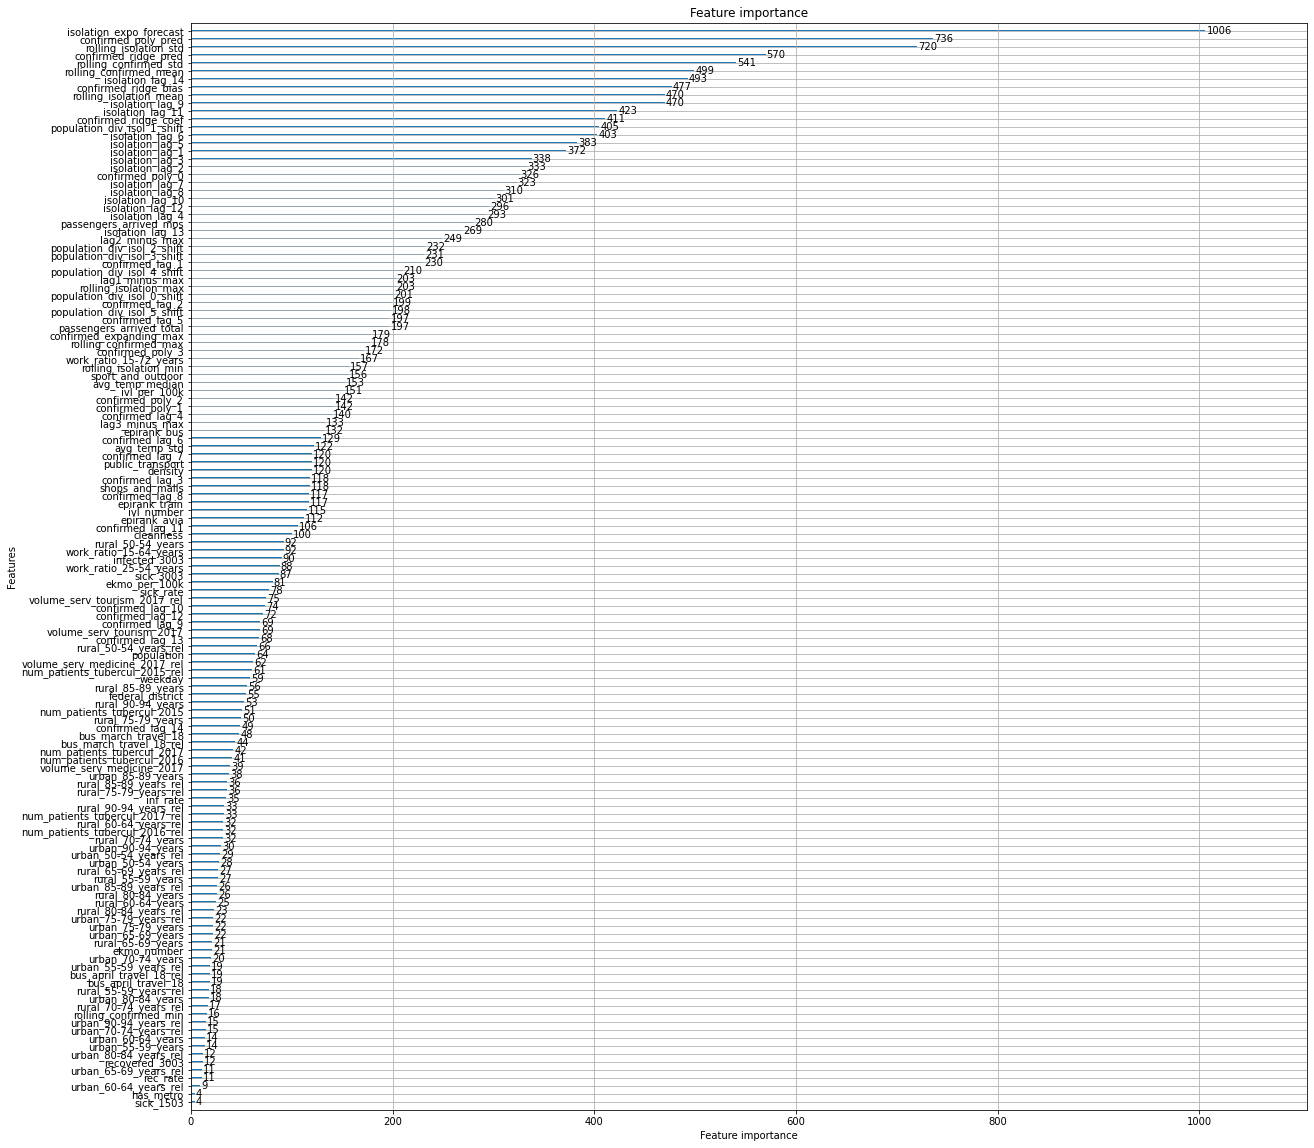

In [34]:
lgb.plot_importance(models['confirmed'], figsize=(20, 20));

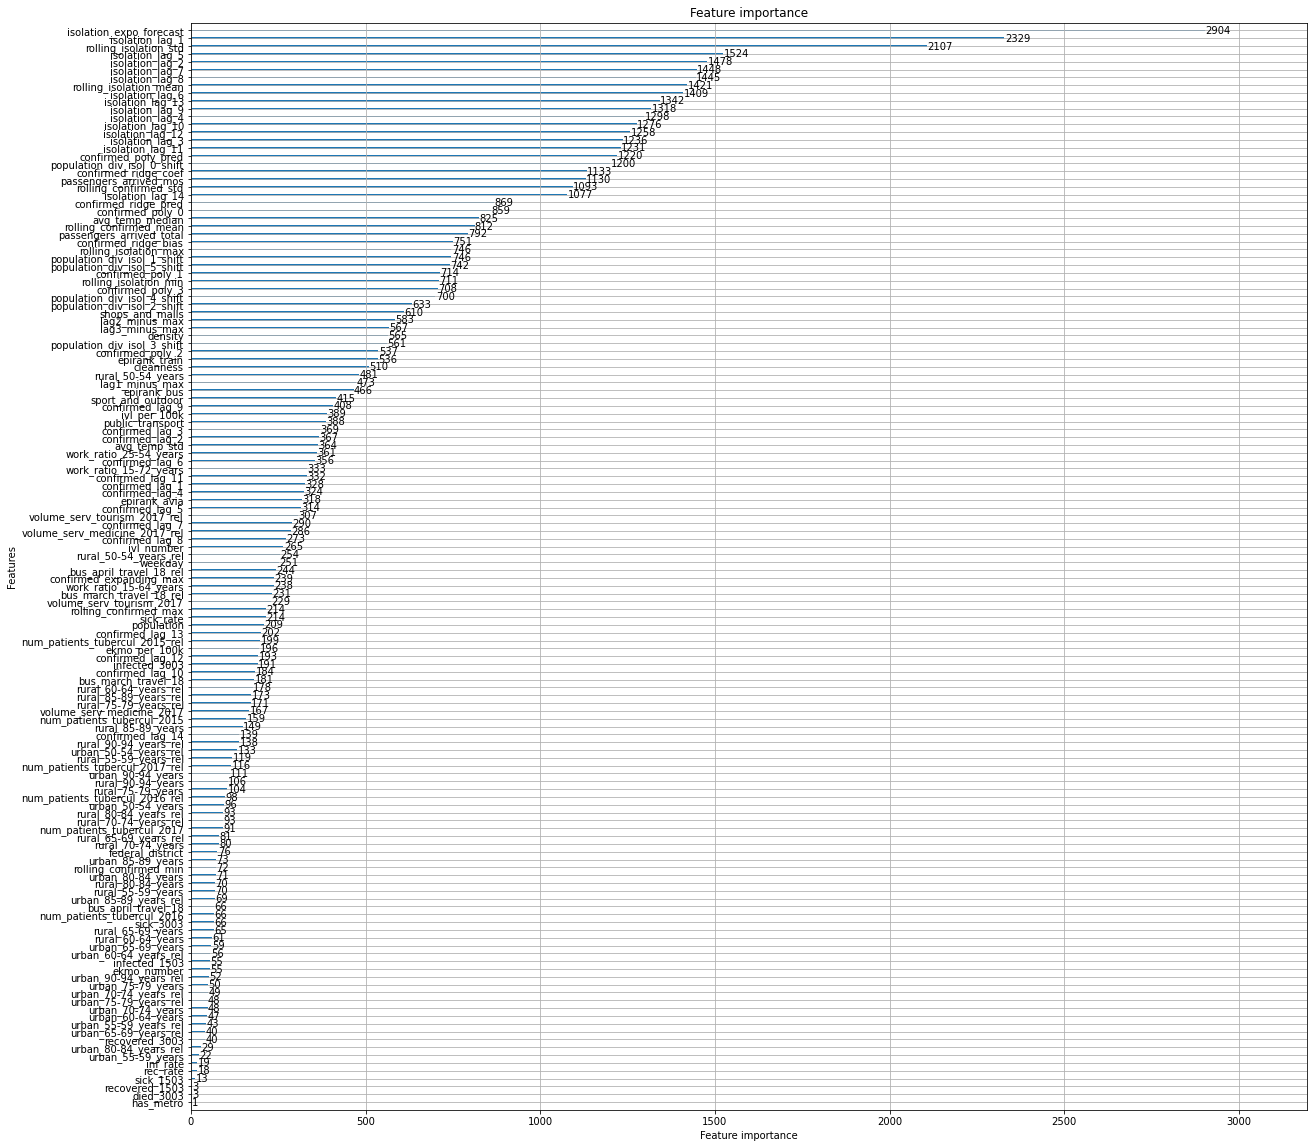

In [35]:
lgb.plot_importance(models['isolation'], figsize=(20, 20));

# Search for the best hyperparams

In [0]:
search_space = {
    # 'objective': ['poisson', 'regression'],
    # 'num_leaves': [15, 31, 63, 127],
    # 'min_data_in_leaf': [15, 25, 35],
    # 'min_gain_to_split':[0.0, 0.1, 0.2, 0.3],
    # 'bagging_fraction': [0.8, 0.9, 1.0],
    # 'bagging_freq': [0, 1, 2, 5], 
    # 'feature_fraction': [0.8, 0.9, 1.0],
    # 'lambda_l2':[0.0, 0.01, 0.05, 0.1],
    'learning_rate': [0.1, 0.03, 0.01, 0.003, 0.001]
}

In [37]:
%%time
improves = True
optimal_params = booster_params
curr_score = crossval(data, 7, optimal_params)[0]

while improves:
    # fine tune one model with others fixed
    for t in targets:
        for param in search_space.keys():
            scores = []
            for param_value in search_space[param]:
                print(f"Model {t}, param {param}, param_value {param_value}")
                optimal_params[t][param] = param_value
                scores.append(crossval(data, 7, optimal_params)[0])
                print(f'Validation scores {scores[-1]}\n\n')
            optimal_params[t][param] = search_space[param][np.argmin(scores)]

    tuned_score = crossval(data, 7, optimal_params)[0]
    improves = tuned_score < curr_score
    if improves:
        curr_score = tuned_score
        with open('optimal_params.txt', 'w') as file:
            file.write(json.dumps(optimal_params))

print(optimal_params)

(2890, 145)
Fitting confirmed's model
[100]	training's poisson: -114.308	training's male: 0.142308
[200]	training's poisson: -114.604	training's male: 0.0798266
[300]	training's poisson: -114.604	training's male: 0.0798035
[400]	training's poisson: -114.604	training's male: 0.0798035
[500]	training's poisson: -114.604	training's male: 0.0798035

(2720, 145)
Fitting isolation's model
[100]	training's l2: 0.000383659	training's male: 0.00129467
[200]	training's l2: 6.92039e-05	training's male: 0.000324241
[300]	training's l2: 2.86695e-05	training's male: 0.000153313
[400]	training's l2: 1.3791e-05	training's male: 9.68379e-05
[500]	training's l2: 7.0413e-06	training's male: 6.56683e-05

2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
Model confirmed, param learning_rate, param_value 0.1
(2890, 145)
Fitting confirmed's model
[100]	training's poisson: -114.308	training's male: 0.142308
[200]	trainin

In [38]:
%%time
score, models = crossval(data.copy(), 7, optimal_params)
print(f"Validation score: {score}")

(2890, 145)
Fitting confirmed's model
[100]	training's poisson: -114.308	training's male: 0.142308
[200]	training's poisson: -114.604	training's male: 0.0798266
[300]	training's poisson: -114.604	training's male: 0.0798035
[400]	training's poisson: -114.604	training's male: 0.0798035
[500]	training's poisson: -114.604	training's male: 0.0798035

(2720, 145)
Fitting isolation's model
[100]	training's l2: 0.000383659	training's male: 0.00129467
[200]	training's l2: 6.92039e-05	training's male: 0.000324241
[300]	training's l2: 2.86695e-05	training's male: 0.000153313
[400]	training's l2: 1.3791e-05	training's male: 9.68379e-05
[500]	training's l2: 7.0413e-06	training's male: 6.56683e-05

2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
Validation score: 0.09617269299584692
CPU times: user 2min 11s, sys: 670 ms, total: 2min 12s
Wall time: 1min 45s


# Make predictions and save submissions

In [39]:
%%time
data = fit_predict_recursively(data, last_train_day)

(2890, 145)
Fitting confirmed's model
[100]	training's poisson: -114.308	training's male: 0.142308
[200]	training's poisson: -114.604	training's male: 0.0798266
[300]	training's poisson: -114.604	training's male: 0.0798035
[400]	training's poisson: -114.604	training's male: 0.0798035
[500]	training's poisson: -114.604	training's male: 0.0798035

(2720, 145)
Fitting isolation's model
[100]	training's l2: 0.000383659	training's male: 0.00129467
[200]	training's l2: 6.92039e-05	training's male: 0.000324241
[300]	training's l2: 2.86695e-05	training's male: 0.000153313
[400]	training's l2: 1.3791e-05	training's male: 9.68379e-05
[500]	training's l2: 7.0413e-06	training's male: 6.56683e-05

2020-04-25 00:00:00
2020-04-26 00:00:00
2020-04-27 00:00:00
2020-04-28 00:00:00
2020-04-29 00:00:00
2020-04-30 00:00:00
2020-05-01 00:00:00
2020-05-02 00:00:00
2020-05-03 00:00:00
CPU times: user 2min 35s, sys: 670 ms, total: 2min 35s
Wall time: 2min 9s


In [40]:
cum_pred = pivot_cum(data, 'confirmed')

plot_ts(cum_pred.iloc[:, 2:].values, x_axis=cum_pred.columns[2:], labels=cum_pred['iso_code'].values)

In [0]:
fp = 'subs/normal.csv'

def to_csv(data, fp='subs/preds.csv'):
    sub = ss.copy()
    sub['date'] = pd.to_datetime(sub['date'])
    preds = data[['date', 'iso_code', 'confirmed']]
    preds['date'] = pd.to_datetime(preds['date'])
    preds = preds.rename({'confirmed': 'prediction_confirmed', 'iso_code': 'region'}, axis=1)
    preds['prediction_confirmed'] = preds.groupby('region')['prediction_confirmed'].cumsum()
    preds['prediction_deaths'] = preds['prediction_confirmed'] * 0.01
    preds[['prediction_confirmed', 'prediction_deaths']] = preds[['prediction_confirmed', 'prediction_deaths']].astype(int)
    preds = preds[preds['date'] >= sub['date'].min()].reset_index(drop=True)

    cp = pd.read_csv('subs/countries_preds.csv')
    cp = cp.rename({'country': 'region'}, axis=1)
    cp['date'] = pd.to_datetime(cp['date'])
    cp = cp[cp['date'] >= sub['date'].min()].reset_index(drop=True)
    s = pd.concat([cp, preds])
    sub = pd.merge(sub[['date', 'region']], s, how='left', on=['date', 'region'])
    sub = sub.ffill(axis=0)
    sub.to_csv(fp, index=False)

to_csv(data, fp=fp)

In [42]:
sub = pd.read_csv(fp)
plot_ts([sub[sub['region'] == 'RU-PRI']['prediction_confirmed'].values], x_axis=sub['date'])